#Water or `lickometer` preprocessing

Water data from experiment 1 shows significant differences between mice unrelated to the infection status. In the cell below, the mice in green are healthy controls (1,4,7) and the mice in red are the infected mice (2,3,5,8, 6 is excluded because it died). 

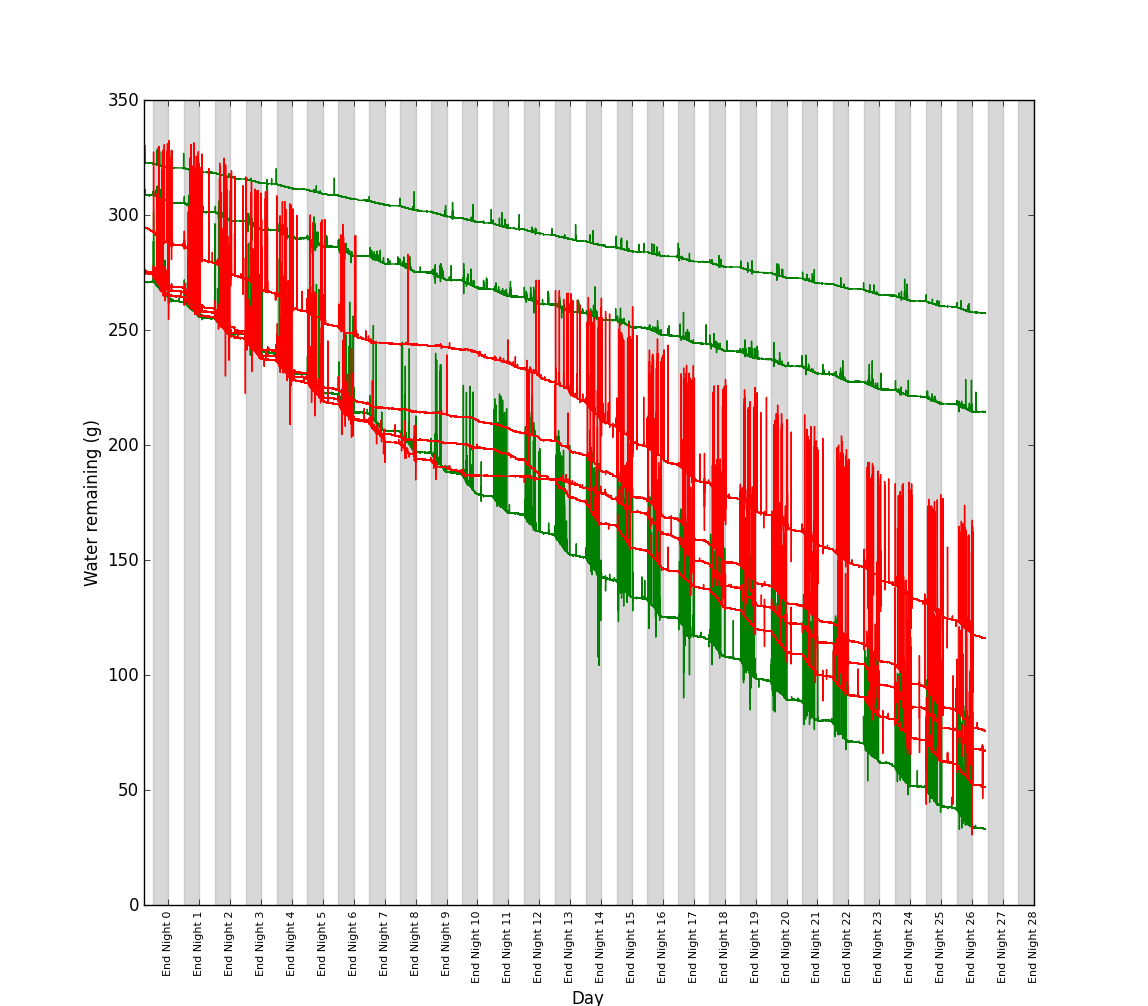

In [1]:
%matplotlib inline
from IPython.display import Image
Image('./drinking/water_usage_exp1.png')

# for y in [w1, w4, w7]:
#     plt.plot(t, y, 'g')
# for y in [w2, w5, w6, w8]:
#     plt.plot(t, y, 'r')
# plt.ylabel('Water remaining (g)')
# plt.xlabel('Day')
# plt.xticks([i[1] for i in e], ['End Night %s' % i for i in range(len(e))], rotation=90, size=8)
# for i in e:
#     plt.axvspan(i[0], i[1], color='gray', alpha=.3)
# plt.show()

For a ~25 day experiment, assuming the mouse drinks ~3ml=3g/d, we'd expect about 75g water loss. The top two traces show some loss of 65.35, and 94.3 grams. This is reasonable. The other traces show between 178 and 230g loss. We assume there is some amount of leakage. To test this, we ran the 'lickometers' without mice. The results were:

The traces for drinking events throughout the night look pretty uniform. Each drop in the weight appears to consist of a downward spike and then recovery as shown below. This image came from animal 1's water usage.

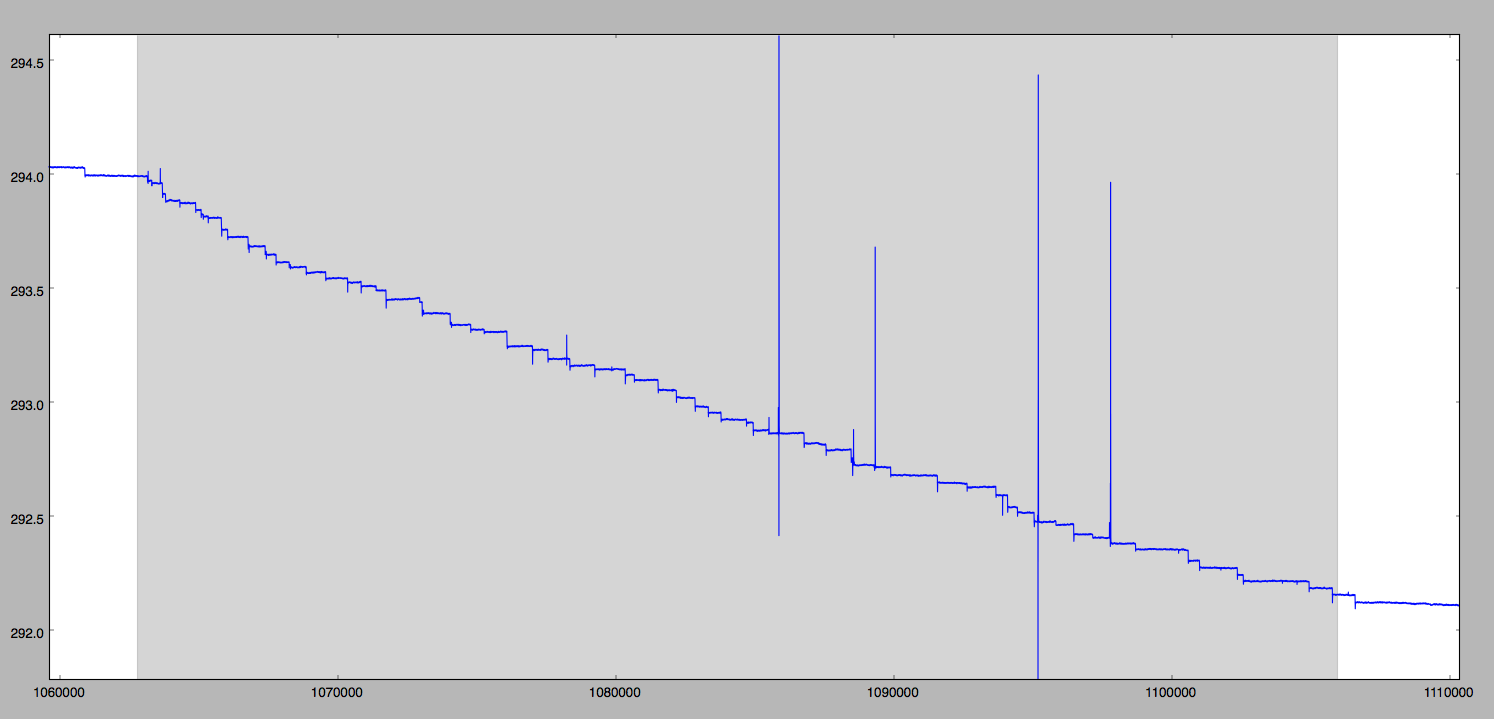

In [2]:
Image('./drinking/water_usage_example.png')

#K-means clustering for feature extraction

Our initial attempt to classify events as drinking (so that we can count them, determine how much has been drunk, etc.) will be based on **`kmeans`** clustering. 

In general, we are attempting to build a **`codebook`** that has a set of signals (vectors) which *span* the space of signals recorded by the water sensor. We are particularly interested in finding something that can tell us when a drink has been taken. 

The `codebook` we are creating will depend very much on the length of the signal we are processing. If we process a collection of signals that are each 10 seconds long, they will look different in many ways than a collection of signals (from the same data) that are 100 seconds long.

At a high level, the input data are traces of water consumption. This means a 1D vector where the `ith` entry is the amount of water remaining in the cage at time `i` (more accurately `i` measurements since the start of the experiment). This data is split at regular intervals into sub-signals of length **`k`**. For instance, if we measured for 1005 seconds, and wanted to look for different signal types in the range of 10 seconds we'd split the data into 100 length 10 signals (and discard the 5 seconds at the end). We'd then have 100 independent vectors to run our computations on (i.e. to classify as closest to different members of our `codebook`).

The `scipy.cluster` documentation suggests that for kmeans clustering it is essential to normalize the columns of our signals matrix (i.e. the features of each vector) to have unit variance. To do this, we divide each column by it's standard deviation. 

We also subtract the mean of the data from each vector (each row). Tests without this subtraction show that the cluster centroids are picked mainly to accomodate the different data scales that happen. Specifically, the mean water level is ~300g at the start of the experiment and ~100g at the end of the experiment for some mice. The centroids picked when the data are not centered end up being far more determined by the general water level than the specific signal changes.


Below is an example of using K-means clustering to find the drinking events in a specific signal. This data is from mouse 1, using 5 clusters, 0 regularization value, and a signal length of 100. The top graph shows the actual water trace (in dark blue) and each window of 100 seconds is colored according to which of the k centroids that signal is closest too. You can see that many of the drops which we beleive to be drinking events are highlighted in either light blue or orange. This means that they are closer to the light blue and orange centroid than they are to the darker blue centroid (which appears to be the centroid representing flat signals).

The bottom graph shows the trace of the centroid vectors (i.e. the means). The green and purple centroid vectors don't show up in the top graph but are found in other parts of the the whole trace. Interestingly, the orange and blue centroids (which are classifying the feeding events) appear to have very constant values. The X axis on the bottom graph represents the position in the vector (so blue_centroid[50] is the closest value - in the sense of minimizing least squared error - to v[50] for all v which are in the blue cluster in the entire experiment).  

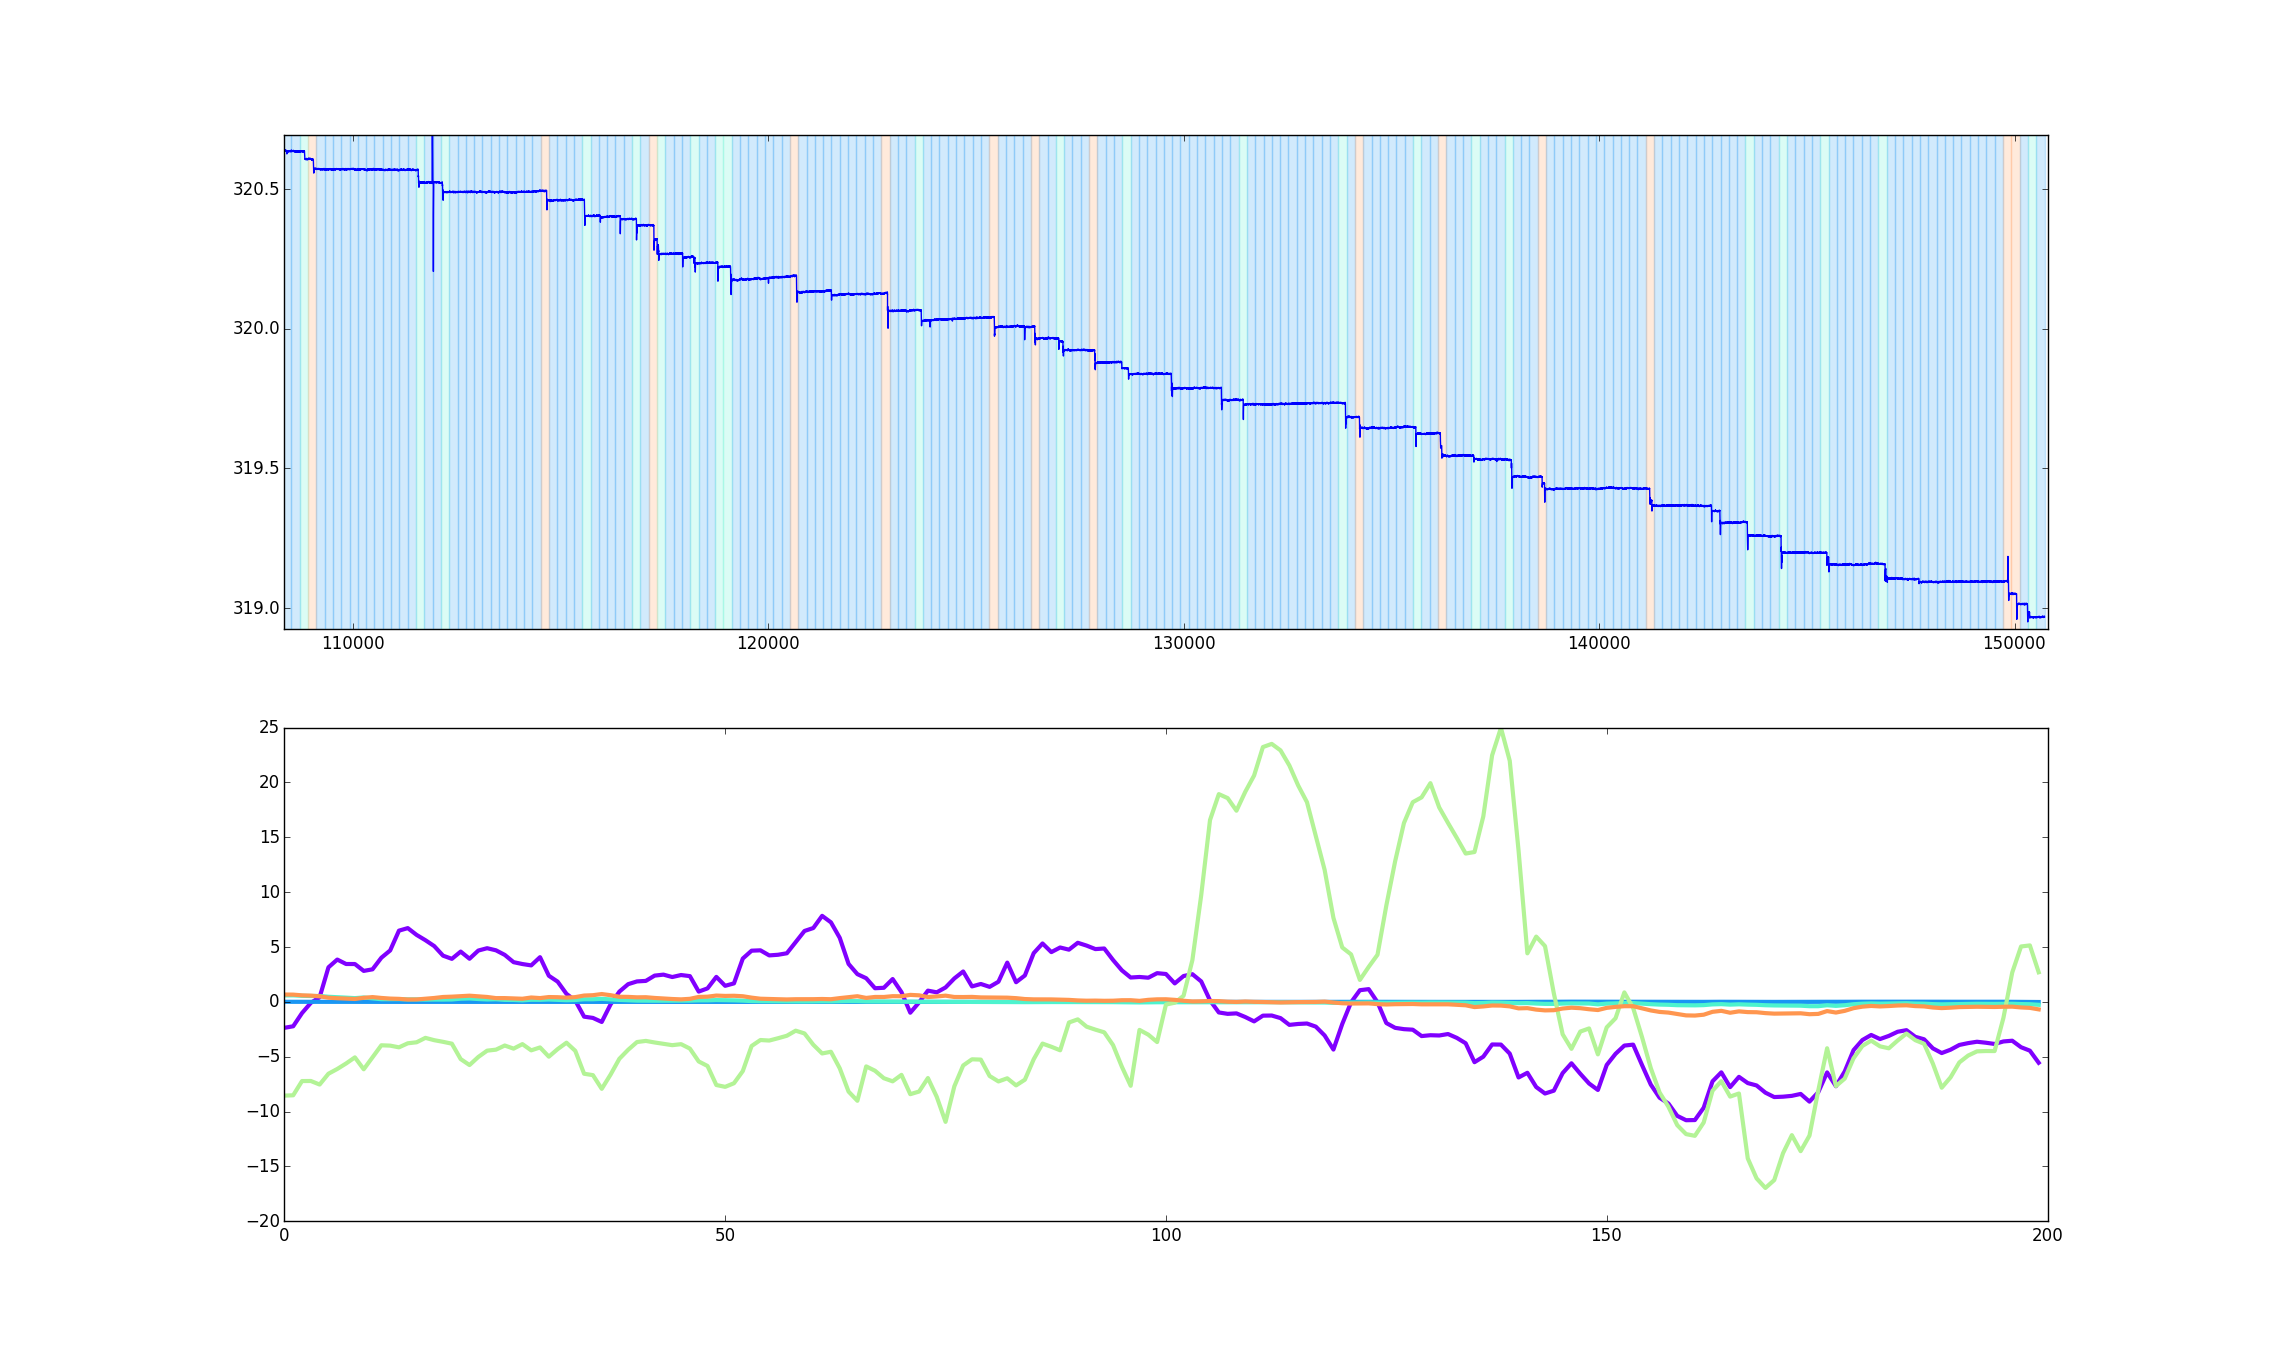

In [6]:
from IPython.display import Image
Image('./drinking/m1_k5_sl200.png')

Below is working code for building k means clustering. It is the same data that generated the plot above, but with different parameters. 

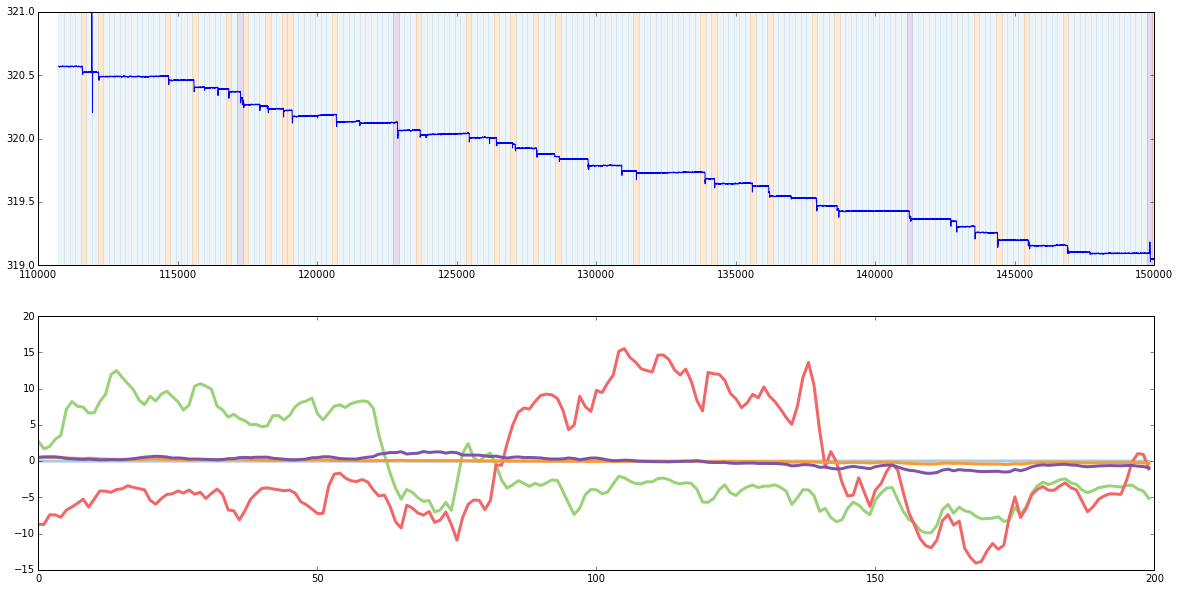

In [15]:
from bcp.feature_extraction import trace_to_signals_matrix
import numpy as np
from scipy.cluster.vq import kmeans, vq
import matplotlib.pyplot as plt

w1 = np.load('../data/exp1/Water_1.npy')
t = np.load('../data/exp1/time.npy')

signal_length = 200
k = 5

colors = [plt.cm.Paired(i/float(k)) for i in range(k)]

_w1 = trace_to_signals_matrix(w1, signal_length, regularization_value=.001)
cb, _ = kmeans(_w1, k)

start_ind = 110000
end_ind = 150000

m_start_ind = start_ind / signal_length
m_end_ind = end_ind / signal_length

obs = _w1[m_start_ind: m_end_ind]
m, d = vq(obs, cb)

f, axarr = plt.subplots(nrows=2, figsize=(20,10))
axarr[0].plot(t[start_ind:end_ind], w1[start_ind:end_ind])

for i in range(len(m)):
    xmin_ind = start_ind + i * signal_length
    xmax_ind = xmin_ind + signal_length
    axarr[0].axvspan(t[xmin_ind], t[xmax_ind], color=colors[m[i]], alpha=.2)
axarr[0].set_xlim(start_ind, end_ind)
axarr[0].set_ylim(319, 321)

for i in range(k):
    axarr[1].plot(cb[i], lw=3, color=colors[i])

# Number in each class in the entire data from mouse 1, and in just the subset we classified.
#print np.bincount(vq(_w1, cb)[0], minlength=k)
#print np.bincount(m, minlength=k)